In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.dag import topological_sort
import matplotlib
import cvxpy as cvx
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

In [2]:
def parse(xml_file):
    return nx.read_graphml(xml_file)

In [3]:
class GrahamCoffman:
    def __call__(self, G, w):
        return self.return_pos(G, w)
    
    @staticmethod
    def topological_sort(G):
        top_V = topological_sort(G)
        top_V = list(top_V)
        return top_V
    
    @staticmethod
    def next_in_V1(v, V, E):
        for e in E:
            if e[0] == v and e[1] in V:
                return True
        return False
    
    def GrahamCoffman(self, G, w):
        top_V = self.topological_sort(G)
        V = list(G.nodes)
        E = list(G.edges)
        L = [[]]
        V1 = top_V.copy()
        while len(V1) != 0:
            ind = max([ind for ind in range(len(V1)) if not self.next_in_V1(V1[ind], V1, E)])
            v = V1[ind]
            if len(L[-1]) < w:
                L[-1].append(v)
            else:
                L.append([v])
            V1.remove(v)
        return L, E
    
    def return_pos(self, G, w):
        L, E = self.GrahamCoffman(G, w)
        pos = {}
        for k, Lk in enumerate(L):
            for indv, v in enumerate(Lk):
                pos[v] = (indv, k)
        return pos

In [31]:
class Dummy:
    def __init__(self, mi_max_iters=100, verbose=False):
        self.mi_max_iters = mi_max_iters
        self.verbose = verbose
    
    def __call__(self, G, w=None):
        return self.return_pos(G)
    
    def opt_y(self, G):
        V = list(G.nodes)
        E = list(G.edges)
        E_ = [(V.index(e[0]), V.index(e[1])) for e in E]
        y = cvx.Variable(len(V), integer=True)
        obj = cvx.sum([y[e[0]] - y[e[1]] - 1 for e in E_])
        constraints = [y >= 1]
        constraints += [y[e[0]] - y[e[1]] >= 1 for e in E_]
        problem = cvx.Problem(cvx.Minimize(obj),
                      constraints)
        problem.solve(solver="GUROBI",
                      verbose=self.verbose,
                      mi_max_iters=self.mi_max_iters)
        return y.value.astype(int)
    
    def return_pos(self, G, w=None):
        y = self.opt_y(G)
        L = [[] for _ in range(max(y))]
        for ind, v in enumerate(G.nodes):
            L[y[ind] - 1].append(v)
        pos = {}
        for k, Lk in enumerate(L):
            for indv, v in enumerate(Lk):
                pos[v] = (indv, k)
        return pos

In [32]:
class GraphVis:
    def __init__(self):
        self.GrahamCoffman = GrahamCoffman()
        self.Dummy = Dummy()
    
    def __call__(self, G, w=None):
        if w is None:
            return self.Dummy(G)
        else:
            return self.GrahamCoffman(G, w)

In [43]:
def test_method(G, w_list):
    method = GraphVis()
    fig, ax = plt.subplots(1, len(w_list), figsize=(30, 15))
    for ind, w in enumerate(w_list):
        pos = method(G, w)
        if w is None:
            ax[ind].set_title("Minimizing # Dummy vertices")
        else:
            ax[ind].set_title("GrahamCoffman, w=%d" % w)
        nx.draw(G, pos, ax=ax[ind])

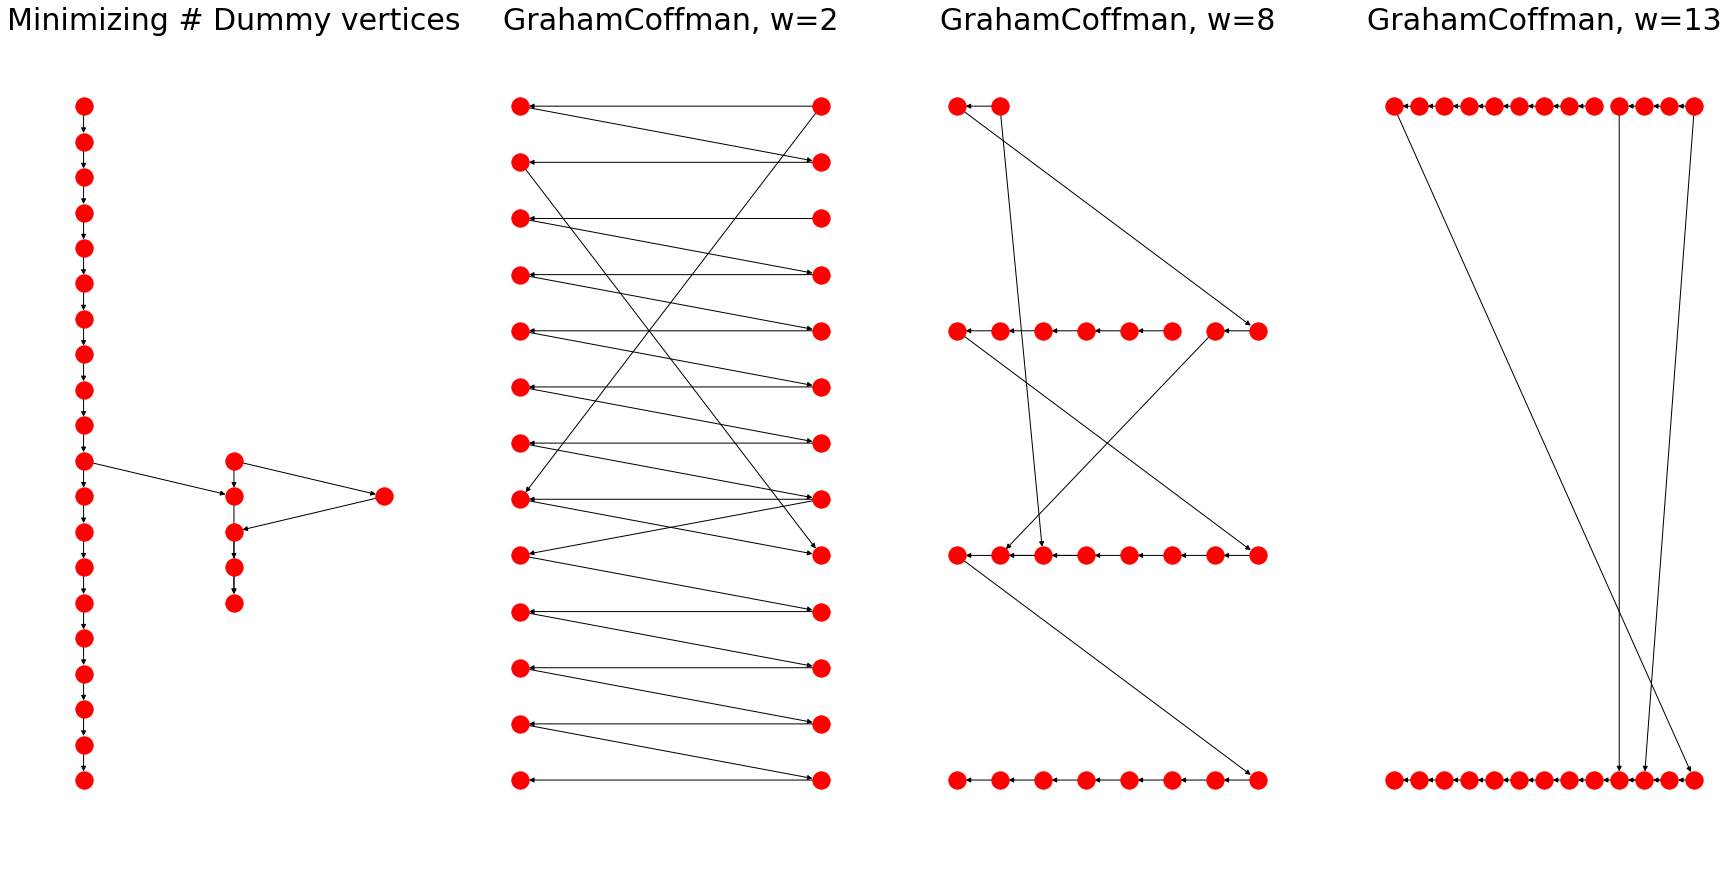

In [44]:
G = parse("flow-test-1-loop-crush.xml")
w_list = [None, 2, 8, 13]
test_method(G, w_list)

25


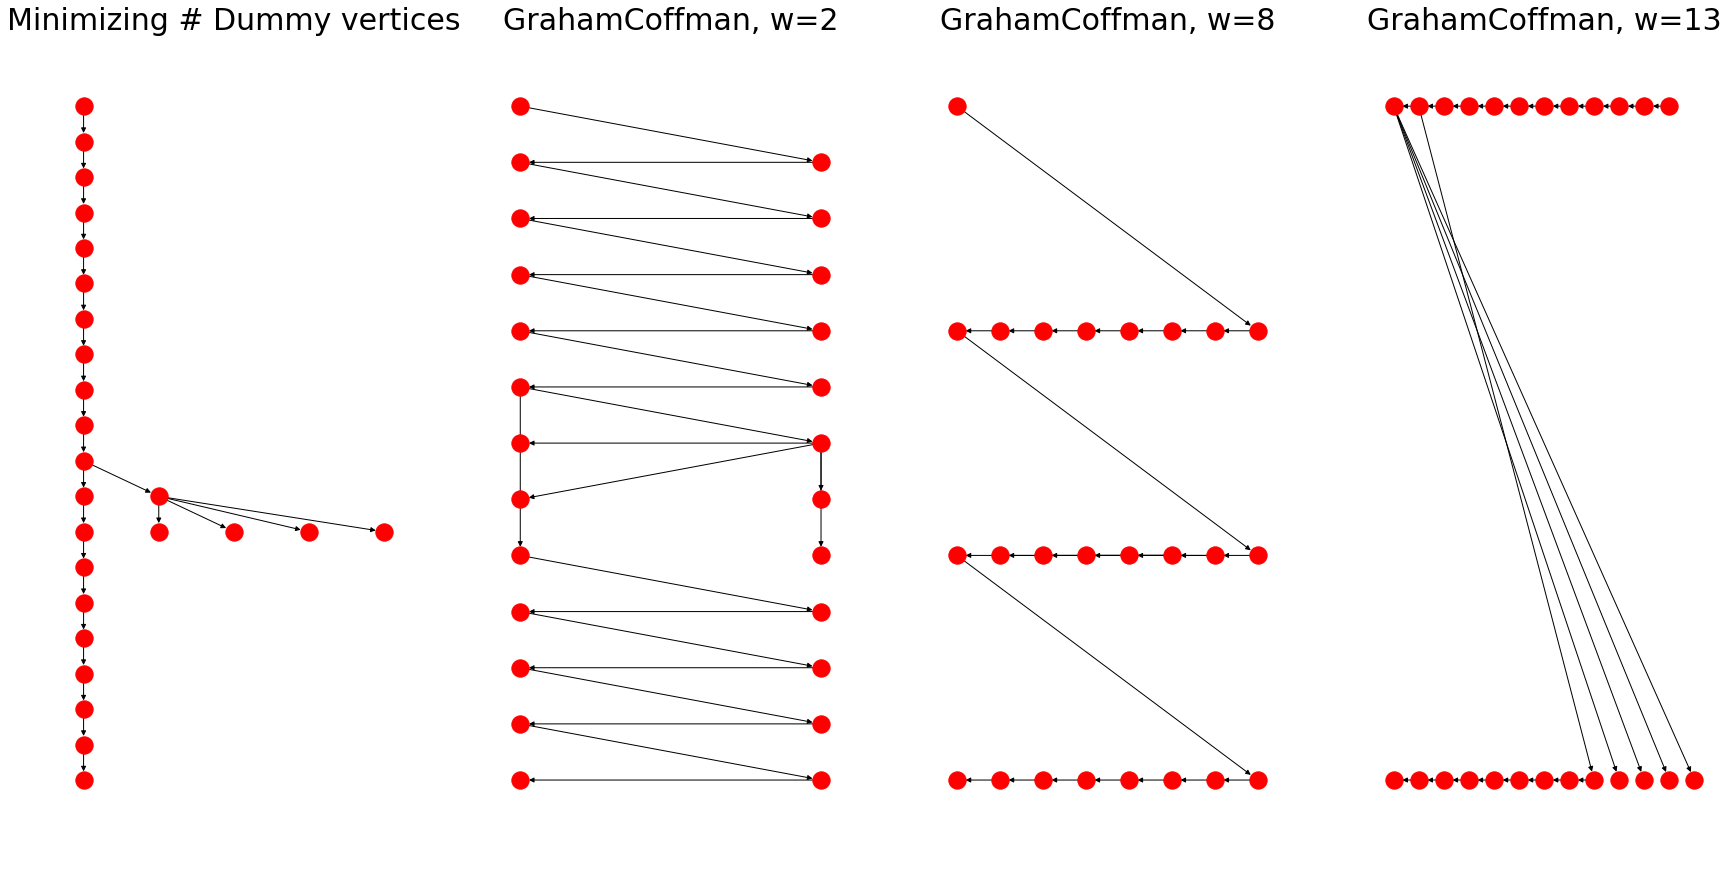

In [46]:
G = parse("flow-test-2-heavy-fruit.xml")
w_list = [None, 2, 8, 13]
test_method(G, w_list)

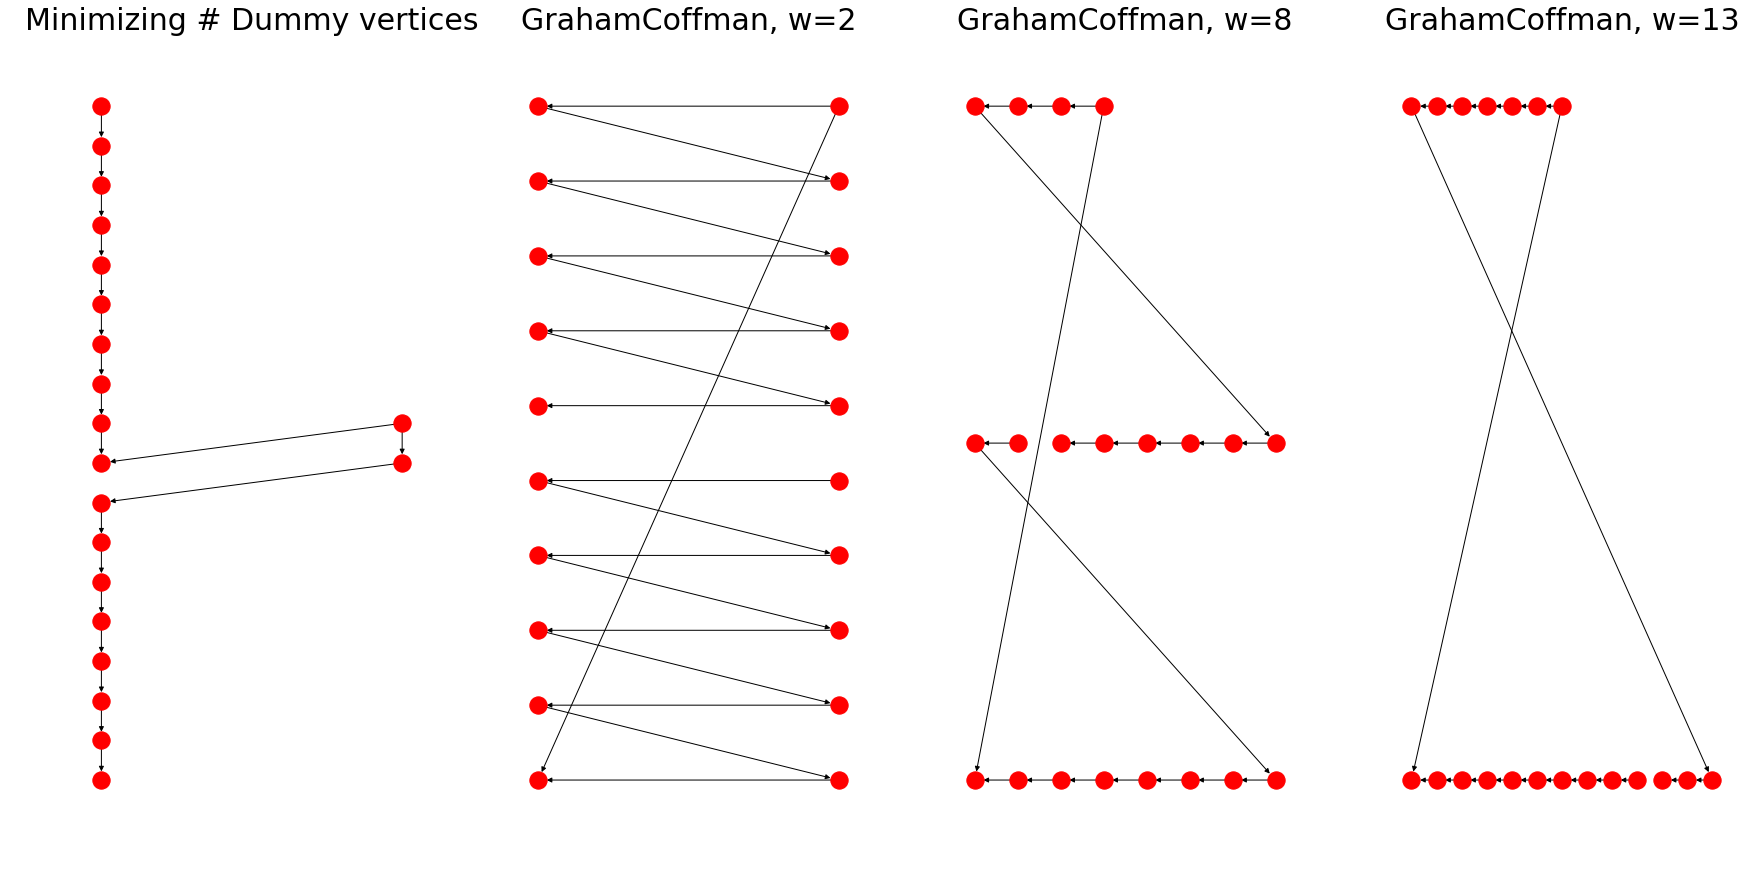

In [47]:
G = parse("flow-test-3-piston.xml")
w_list = [None, 2, 8, 13]
test_method(G, w_list)